In [2]:
import os
import sys

root_path = os.path.abspath("..")  
if root_path not in sys.path:
    sys.path.insert(0, root_path)
os.chdir("..")

In [5]:
from data.loader import load_complete_dataset
from data.preprocessing import add_module_columns
import matplotlib.pyplot as plt
dataset=load_complete_dataset()
dataset=add_module_columns(dataset)
dataset.shape

(3930798, 16)

k= 1 score= 133577424.96966308
k= 2 score= 76627307.52839899
k= 3 score= 70234496.46906495
k= 4 score= 54861797.32749588
k= 5 score= 47789978.195954114
k= 6 score= 38540129.061430156
k= 7 score= 34638722.84844886
k= 8 score= 31763302.594234724
k= 9 score= 28918244.777720988
k= 10 score= 27603688.881522037
k= 11 score= 25800646.763426486
k= 12 score= 24958115.74401397
k= 13 score= 23155123.11405998
k= 14 score= 21974773.4421323
k= 15 score= 20828448.75236445
k= 16 score= 19377885.020406876
k= 17 score= 18494039.09218428
k= 18 score= 17750564.763856128
k= 19 score= 17289225.70172945
k= 20 score= 16852860.487279966
k= 21 score= 16201969.26814265
k= 22 score= 16148243.381046942
k= 23 score= 15650777.697189359
k= 24 score= 15113455.419283684
k= 25 score= 14828796.61175731
k= 26 score= 14477182.471700918
k= 27 score= 14078579.872754782
k= 28 score= 13848636.295828257
k= 29 score= 13508481.090312455
k= 30 score= 13098086.293258404
k= 31 score= 12857034.796456316
k= 32 score= 12632918.6106343


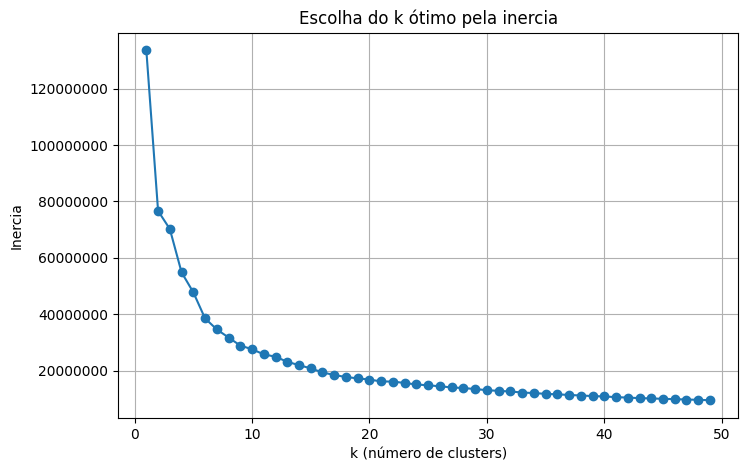

In [6]:
import numpy as np

def compute_wcss(centers, groups_by_centers): #WCSS (Within-Cluster Sum of Squares)
    total_wcss = 0
    for i, group in enumerate(groups_by_centers):    
        if len(group) == 0:
            print("wtf")
        distances = np.linalg.norm(group - centers[i], axis=1)
        total_wcss += np.sum(distances ** 2)
    return total_wcss

wcss_by_k=[]
k_values=range(1,50)
from sklearn.cluster import KMeans

modules=dataset[["accelerometer_x","accelerometer_y","accelerometer_z"]].to_numpy()

for k in k_values:
    #centers,groups_by_centers=k_means(data=accelorometer_cordinates,k=k,iterations=500)
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(modules)
    score = kmeans.inertia_

    #score=compute_wcss(groups_by_centers, centers)
    wcss_by_k.append(score)
    print("k=",k,"score=",score)
plt.figure(figsize=(8,5))
plt.plot(k_values, wcss_by_k, marker='o')
plt.xlabel("k (número de clusters)")
plt.ylabel("Inercia")
plt.title("Escolha do k ótimo pela inercia")
plt.grid(True)
plt.ticklabel_format(style='plain', axis='both')

plt.show()

A gerar Clusters e Gráficos 3D...


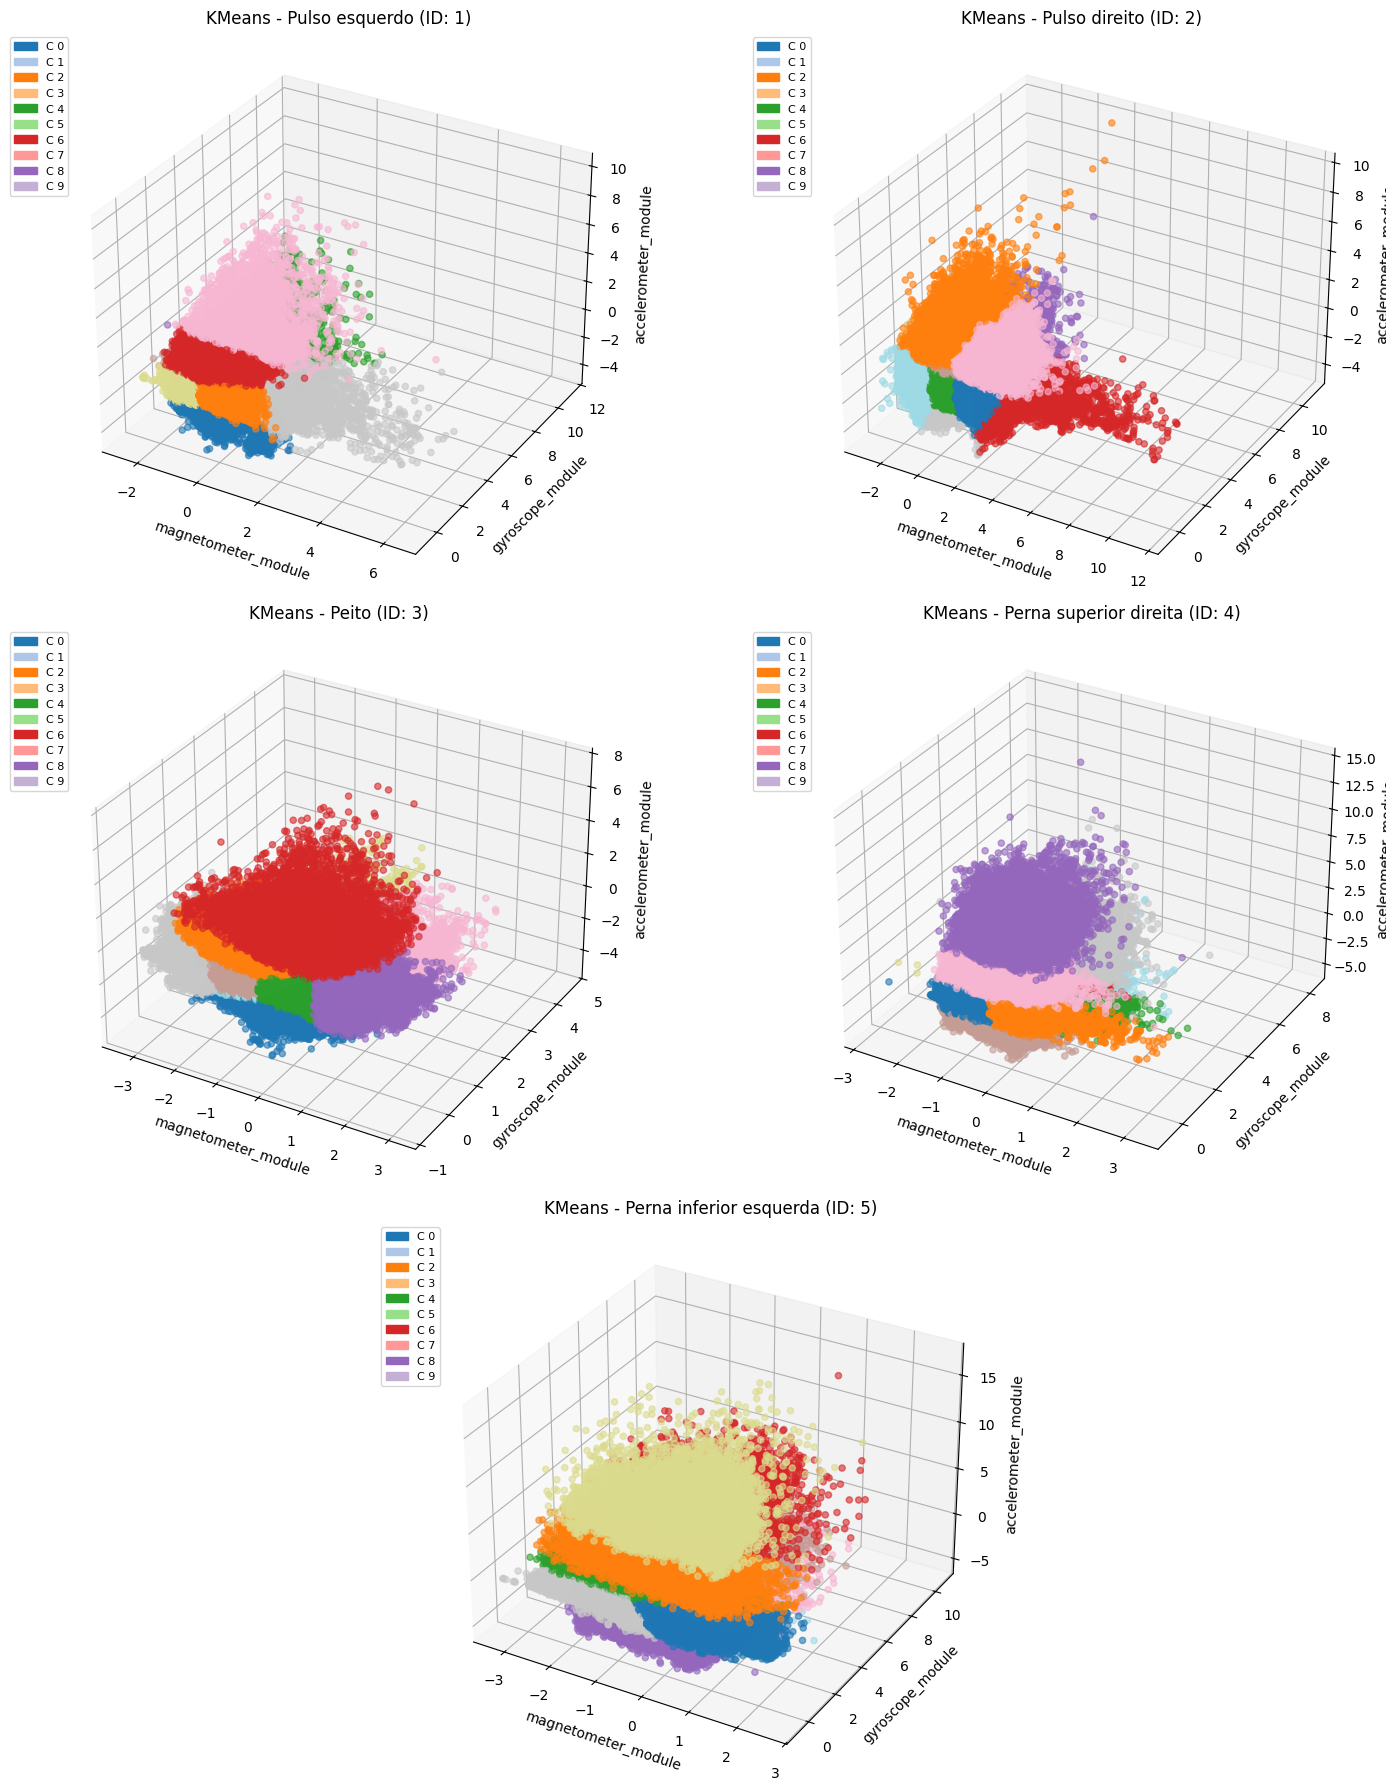

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler # Note: Fixed import (was discriminant_analysis)

# Assuming these are defined elsewhere as in your snippet
from config.constants import COLUMNS_MODULE, DEVICE_LABELS, DEVICES

# 1. Reset index to ensure alignment between DataFrame indices and NumPy array positions
dataset = dataset.reset_index(drop=True) 

scaler = StandardScaler()
subset = scaler.fit_transform(dataset[COLUMNS_MODULE])

dataset['Cluster'] = -1 

# Visual Configurations
n_sensors = min(len(DEVICES), 5)
n_cols = 2
n_rows = int(np.ceil(n_sensors / n_cols))

fig = plt.figure(figsize=(15, 6 * n_rows))
gs = GridSpec(n_rows, n_cols, figure=fig)

print("A gerar Clusters e Gráficos 3D...")

for i, sensor in enumerate(DEVICES[:n_sensors]):
    row = i // n_cols
    col = i % n_cols

    # Layout logic
    if (row == n_rows - 1) and (n_sensors % n_cols == 1):
        ax = fig.add_subplot(gs[row, 0:2], projection='3d')
    else:
        ax = fig.add_subplot(gs[row, col], projection='3d')

    sensordata = dataset[dataset["device_id"] == sensor]
    
    if sensordata.empty:
        continue
        
    # --- FIX STARTS HERE ---
    # We slice 'subset' (the numpy array) using the indices of the current rows
    # This ensures 'modules' only contains data for THIS sensor.
    modules = subset[sensordata.index] 
    # --- FIX ENDS HERE ---

    kmeans = KMeans(n_clusters=10, random_state=42)
    labels = kmeans.fit_predict(modules)
    centroids = kmeans.cluster_centers_

    # Now lengths match: sensordata.index has N rows, and labels has N items
    dataset.loc[sensordata.index, 'Cluster'] = labels

    scatter = ax.scatter(
        modules[:, 0], modules[:, 1], modules[:, 2],
        c=labels, cmap='tab20', s=20, alpha=0.6
    )

    ax.scatter(
        centroids[:, 0], centroids[:, 1], centroids[:, 2],
        c='black', s=150, marker='X', label='Centróides'
    )

    unique_labels = np.unique(labels)
    colors = [plt.cm.tab20(l / 19) for l in unique_labels] 
    legend_patches = [mpatches.Patch(color=c, label=f'C {l}') for l, c in zip(unique_labels, colors)]
    
    ax.legend(handles=legend_patches, loc='upper left', fontsize=8, ncol=1, bbox_to_anchor=(-0.1, 1))

    ax.set_xlabel(COLUMNS_MODULE[0])
    ax.set_ylabel(COLUMNS_MODULE[1])
    ax.set_zlabel(COLUMNS_MODULE[2])
    ax.set_title(f'KMeans - {DEVICE_LABELS[i]} (ID: {sensor})')

plt.tight_layout()
plt.show()



In [11]:
dataset.columns

Index(['device_id', 'accelerometer_x', 'accelerometer_y', 'accelerometer_z',
       'gyroscope_x', 'gyroscope_y', 'gyroscope_z', 'magnetometer_x',
       'magnetometer_y', 'magnetometer_z', 'timestamp', 'actitivy_label',
       'participant_id', 'magnetometer_module', 'gyroscope_module',
       'accelerometer_module', 'Cluster'],
      dtype='object')

In [15]:

from config.constants import ACRONYM_LABELS
import pandas as pd

id_to_label = {i+1: label for i, label in enumerate(ACRONYM_LABELS)}


percentual = pd.crosstab(
    index=[dataset['device_id'], dataset['Cluster']], 
    columns=dataset['actitivy_label'], 
    normalize='index'
) * 100


percentual = percentual.rename(columns=id_to_label)
unique_devs = dataset['device_id'].unique()

print("Tabela 'percentual' criada com sucesso.")

Tabela 'percentual' criada com sucesso.


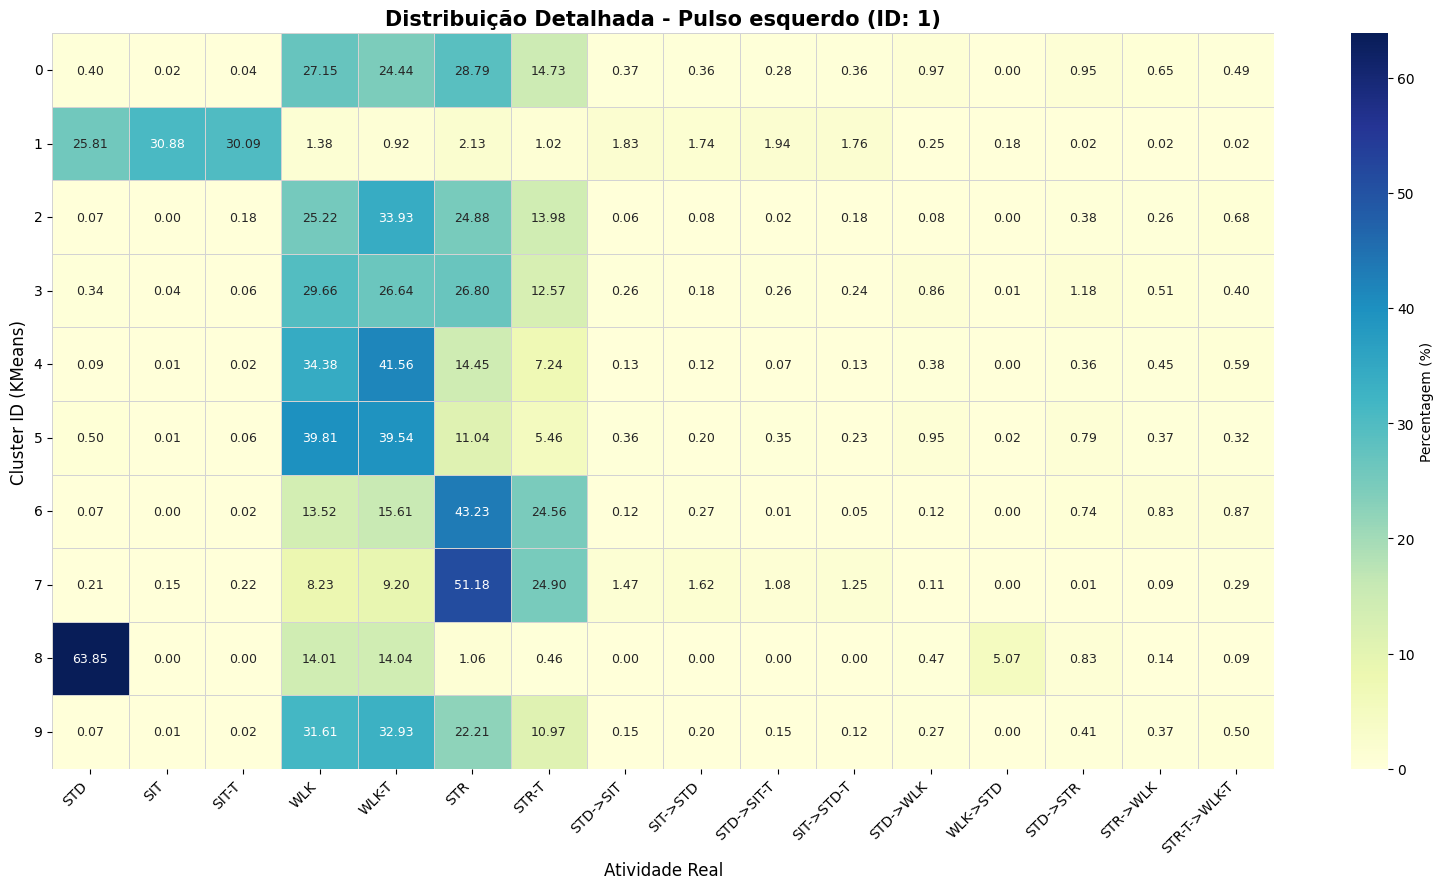

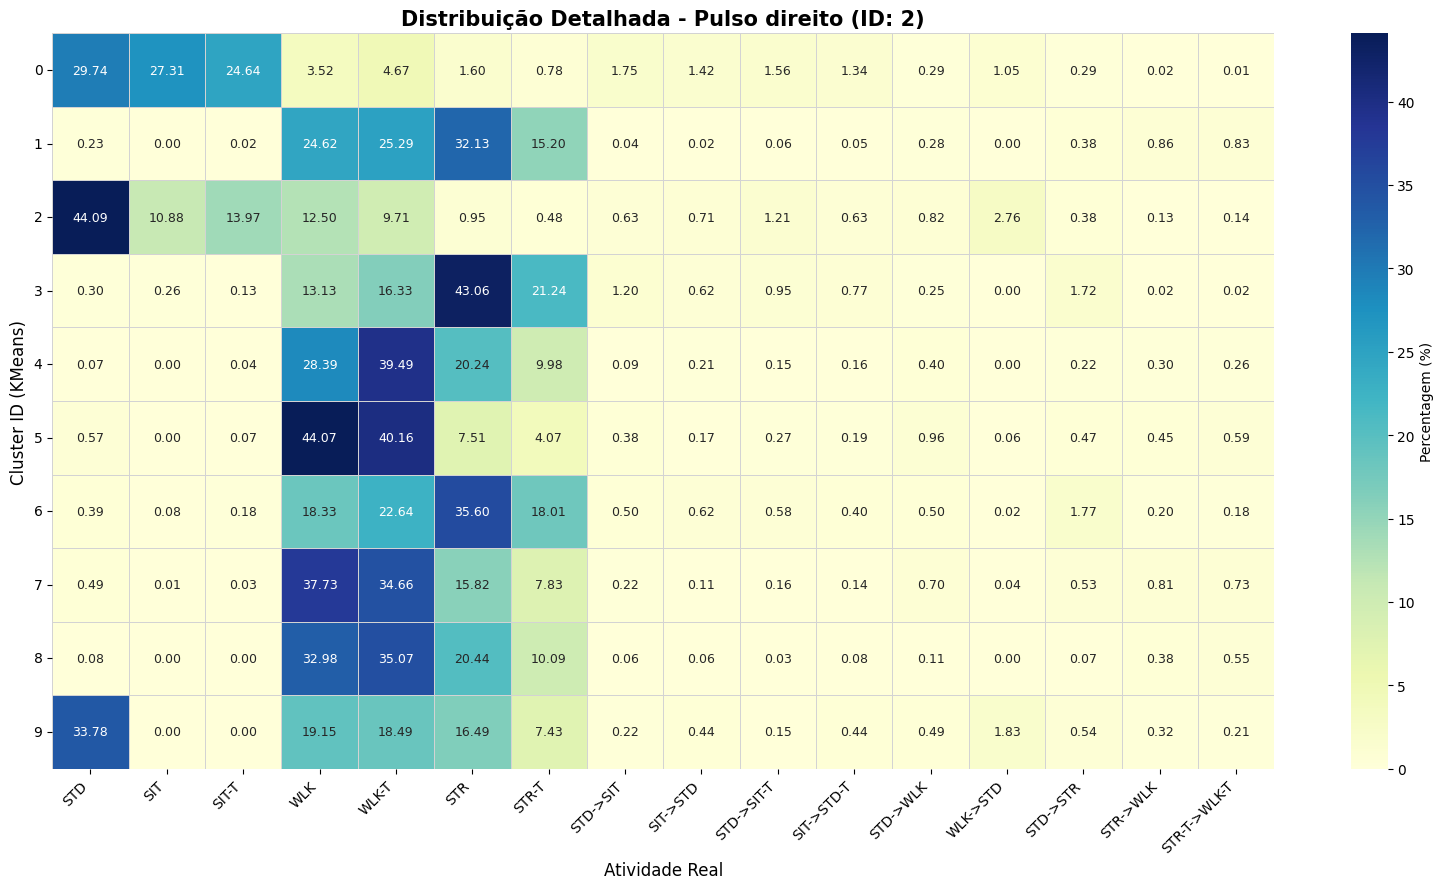

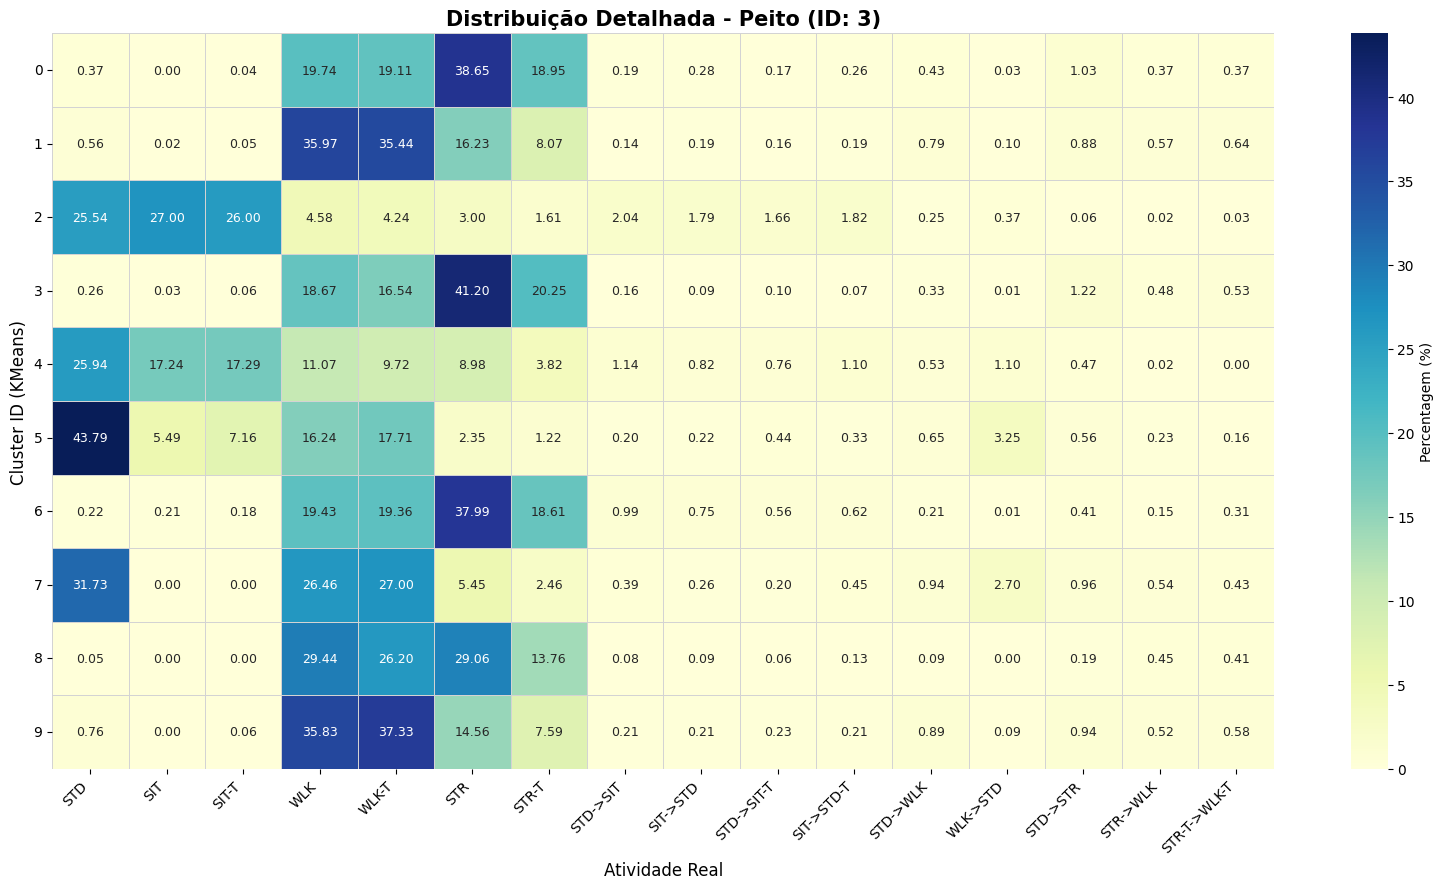

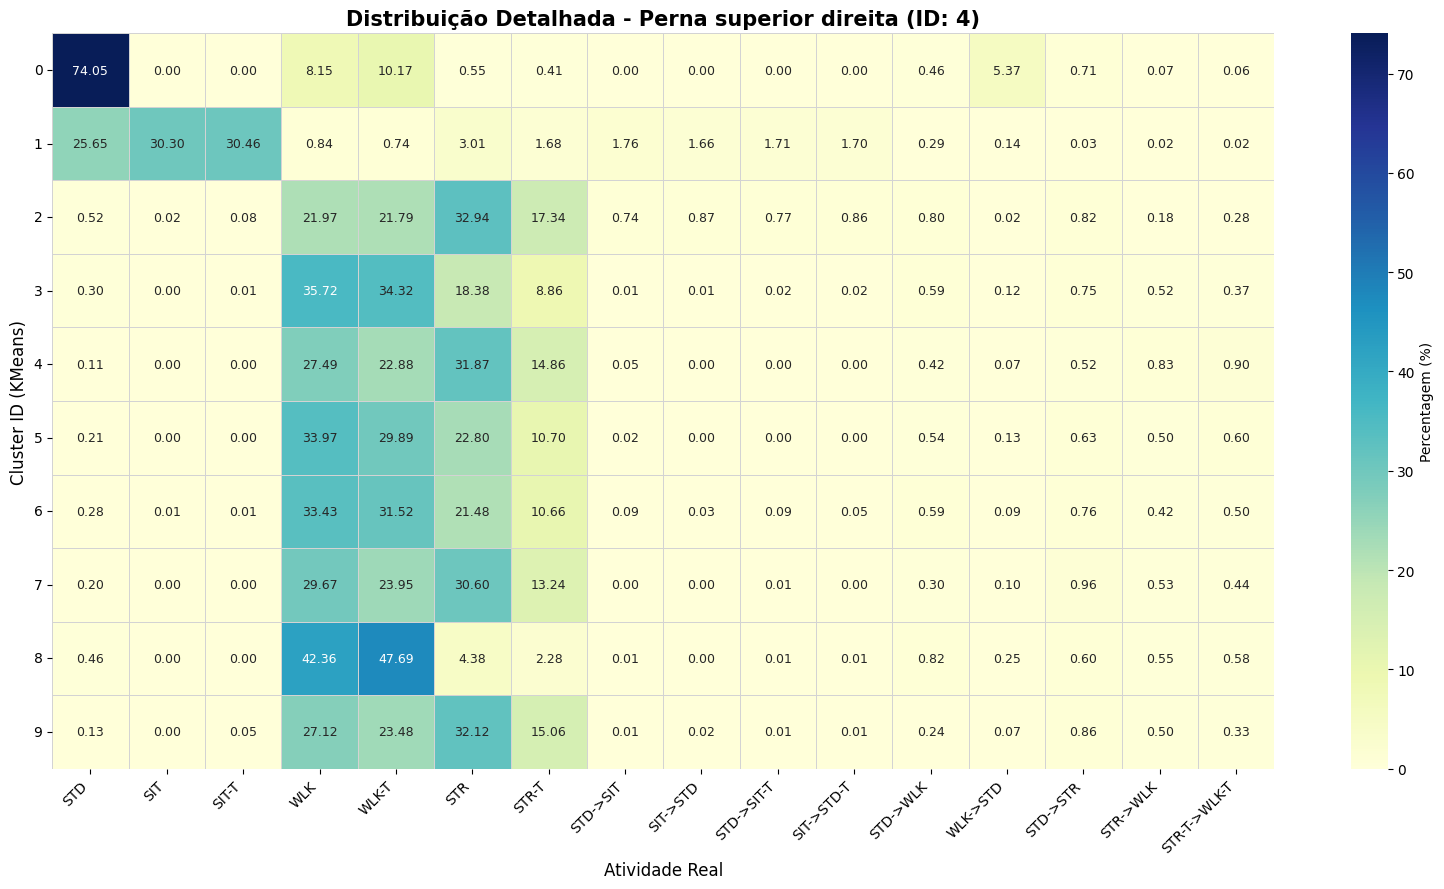

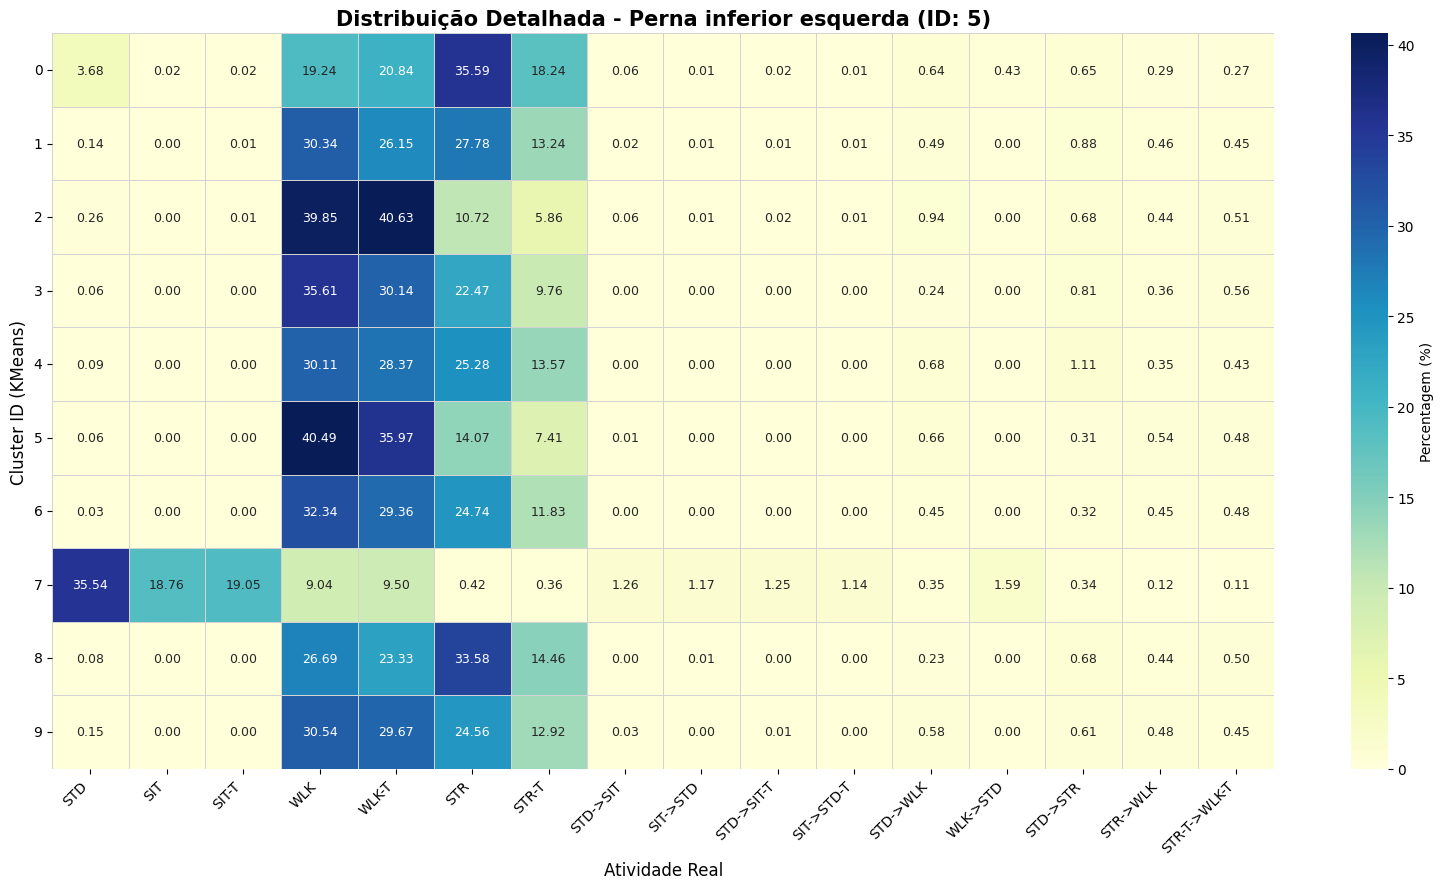

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from config.constants import ACTIVITY_LABELS, DEVICE_LABELS

ALL_LABELS_ORDERED = [id_to_label[i] for i in sorted(id_to_label.keys())]

for dev in unique_devs:
    dev_int = int(dev)
    
    if dev not in percentual.index.get_level_values(0):
        continue
    
    # Selecionar e Reindexar (para garantir que colunas a 0 aparecem)
    subset = percentual.loc[dev]
    subset = subset.reindex(columns=ALL_LABELS_ORDERED, fill_value=0)
    
    plt.figure(figsize=(16, 9))
    
    ax = sns.heatmap(
        subset, 
        annot=True, 
        fmt=".2f",          
        annot_kws={"size": 9},
        cmap="YlGnBu", 
        cbar_kws={'label': 'Percentagem (%)'},
        linewidths=0.5,
        linecolor='lightgray'
    )
    
    # Títulos e Eixos
    label_name = DEVICE_LABELS[dev_int-1] if (dev_int-1) < len(DEVICE_LABELS) else f"Device {dev_int}"
    plt.title(f"Distribuição Detalhada - {label_name} (ID: {dev_int})", fontsize=15, fontweight='bold')
    plt.ylabel("Cluster ID (KMeans)", fontsize=12)
    plt.xlabel("Atividade Real", fontsize=12)
    
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()


In [14]:
import numpy as np
import pandas as pd

# ==============================================================================
# RELATÓRIO DE DENSIDADE (APENAS TEXTO)
# ==============================================================================
print("\n=== Relatório de Densidade por Sensor (Pontos & Percentagens) ===\n")

# 1. Filtrar apenas dados processados (Cluster != -1)
df_valid = dataset[dataset['Cluster'] != -1]
unique_devs = sorted(df_valid['device_id'].unique())

for dev in unique_devs:
    # Obter nome legível do sensor (se a lista existir)
    dev_int = int(dev)
    dev_name = DEVICE_LABELS[dev_int-1] if 'DEVICE_LABELS' in globals() and (dev_int-1) < len(DEVICE_LABELS) else f"Device {dev_int}"
    
    print(f"--- {dev_name} (ID: {dev_int}) ---")
    
    # 2. Obter os clusters apenas deste sensor
    labels = df_valid[df_valid['device_id'] == dev]['Cluster'].to_numpy()
    
    # 3. Calcular contagens e percentagens
    unique, counts = np.unique(labels, return_counts=True)
    percentages = counts / counts.sum() * 100

    # 4. O teu print formatado
    # Uso 'cluster_id' vindo do unique para garantir que o número do cluster é o correto
    for cluster_id, cnt, pct in zip(unique, counts, percentages):
        print(f"Cluster {cluster_id}: {cnt} points, {pct:.2f}% of total")
        
    print("") # Linha em branco para separar os sensores visualmente


=== Relatório de Densidade por Sensor (Pontos & Percentagens) ===

--- Pulso esquerdo (ID: 1) ---
Cluster 0: 72344 points, 9.11% of total
Cluster 1: 277075 points, 34.89% of total
Cluster 2: 17714 points, 2.23% of total
Cluster 3: 39725 points, 5.00% of total
Cluster 4: 48382 points, 6.09% of total
Cluster 5: 107551 points, 13.54% of total
Cluster 6: 10746 points, 1.35% of total
Cluster 7: 18757 points, 2.36% of total
Cluster 8: 140156 points, 17.65% of total
Cluster 9: 61792 points, 7.78% of total

--- Pulso direito (ID: 2) ---
Cluster 0: 255930 points, 32.74% of total
Cluster 1: 22293 points, 2.85% of total
Cluster 2: 128031 points, 16.38% of total
Cluster 3: 50395 points, 6.45% of total
Cluster 4: 40832 points, 5.22% of total
Cluster 5: 66087 points, 8.45% of total
Cluster 6: 23378 points, 2.99% of total
Cluster 7: 72727 points, 9.30% of total
Cluster 8: 50432 points, 6.45% of total
Cluster 9: 71702 points, 9.17% of total

--- Peito (ID: 3) ---
Cluster 0: 40579 points, 5.32% of tot